# Siamese Network

A Siamese Network is a special type of neural network architecture designed to compare two inputs. The general workflow of a Siamese Network is as follows.
 - A pair of images is presented to the network as input.
 - The network processes each input separately to produce embeddings (feature vectors).
 - These embeddings are then compared using a similarity function or a distance metric.

A Siamese network is trained to minimize the distance between embeddings of similar inputs and maximize the distance between embeddings of dissimilar inputs. This makes the network learn the essential characteristics of the inputs that are important for the comparison. Siamese Networks are particularly useful when the amount of labeled data is limited, as they focus on relative comparisons rather than absolute classifications. Once trained, they can generalize to unseen classes without the need for retraining.

In this tutorial, we will implement a Siamese Network to compare images of handwritten digits from the MNIST dataset. We will train the network using the contrastive loss function originally proposed by Chopra, Hadsell, and LeCun in 2005.


In [1]:
import torch
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

## Creating the network

The first step is to define a neural network that processes the input images and produces embeddings. Generally, this network is composed of three parts.
 - **Backbone:** A series of convolutional and pooling layers to extract features from the input image.
 - **Neck:** A small number of layers to further process the extracted features into a compact representation. This typically involves a flattening layer followed by one or more fully-connected layers, nonlinear activations, and possibly batch normalization.
 - **Head:** A final set of layers to prepare the embeddings for comparison with the chosen loss function. This usually involves a normalization layer, and depending on the loss function, a fully-connected layer. As the head is only used during training, it may be included in the loss function, rather than the model itself.

![Embedding model](pics/EmbeddingNet.png)

### Backbone

The backbone of the network is responsible for extracting features from the input images. It is best practice to use a pre-trained model as the backbone, as it can provide better performance with less training data. However, for this tutorial, we define a simple backbone consisting of several convolutional and pooling layers with ReLU activations.

In [2]:
class Backbone(torch.nn.Sequential):

    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(1, 64, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(64, 128, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

Let's test the backbone with a random input tensor.

In [3]:
x = torch.randn(10, 1, 28, 28)

backbone = Backbone()
y = backbone(x)

print('Backbone output:', '...', *y.shape[1:])

Backbone output: ... 256 3 3


### Neck

The neck of the network is responsible for further processing the extracted features into a compact representation. In this tutorial, we use a few fully-connected layers with ReLU activations to create the neck. We also include a flatten layer to convert the 3D tensor coming from the backbone into a 1D tensor suitable for the fully-connected layers.

In [4]:
class Neck(torch.nn.Sequential):

    def __init__(self, out_dim):
        super().__init__(
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 3 * 3, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, out_dim),
        )

Let's test the neck with a random input tensor.

In [5]:
x = torch.randn(10, 256, 3, 3)

neck = Neck(50)
y = neck(x)

print('Neck output:', '...', *y.shape[1:])

Neck output: ... 50


### Embedding model

The embedding model is the combination of the backbone and neck of the network. It converts the input images into embeddings that can be compared using a similarity function or a distance metric.

In [6]:
class EmbeddingNet(torch.nn.Module):

    def __init__(self, out_dim):
        super().__init__()
        self.backbone = Backbone()
        self.neck = Neck(out_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        return x

Let's test the embedding model with a random input tensor.

In [7]:
x = torch.randn(10, 1, 28, 28)

model = EmbeddingNet(50)
y = model(x)

print('Model output:', '...', *y.shape[1:])

Model output: ... 50


## Contrastive loss

Given a pair of embeddings and a binary label indicating whether the embeddings originate from similar or dissimilar inputs, the contrastive loss function is defined by the following formula.

$$
\mathcal{L}_{\rm pair}(z_1, z_2, y) = y \, \|z_1 - z_2\|^2 + (1 - y) \, \max(0, m - \|z_1 - z_2\|)^2
$$

Where:
 - $z_1$ and $z_2$ are the embeddings of a pair of inputs.
 - $y$ is the binary label indicating whether the inputs are similar ($y=1$) or dissimilar ($y=0$).
 - $m$ is the margin that controls how far apart the embeddings of dissimilar inputs should be.

### Intuition

The contrastive loss function is composed of two terms. Only one of these terms is active for each pair of embeddings, depending on the binary label.

 - **Positive term.** If the inputs are similar ($y=1$), the loss is the squared Euclidean distance between their embeddings. This term encourages the network to bring the embeddings as close together as possible.

 - **Negative term.** If the inputs are dissimilar ($y=0$), the loss is the squared hinge distance between their embeddings. This term encourages the network to push the embeddings apart by at least a margin $m$. If the distance between the embeddings is already greater than the margin, the loss is zero.
 
 The role of the margin is that, when the embeddings produced for a negative pair are distant enough, no efforts are wasted on enlarging that distance, so further training can focus on more difficult pairs.

 ![Contrastive loss](pics/pair-loss.png)

### Implementation

Let's implement the contrastive loss function in PyTorch. The approach can vary depending on the type of labels available. In this tutorial, we assume that we have a classification dataset. Hence, we create a custom loss function that takes a batch of embeddings and their corresponding class labels as input. The loss function computes pairwise distances between embeddings, determines whether pairs belong to the same class, and applies the contrastive loss accordingly.

#### Helper function

Now that we have outlined the goal of our implementation, let's proceed with the actual coding. We start by defining an helper function that determines the positive and negative pairs in a batch. Using the masks returned by this function, we can efficiently select the relevant pairs when computing the loss.

In [8]:
def get_similarity_masks(labels: torch.IntTensor) -> tuple[torch.BoolTensor, torch.BoolTensor]:
    """
    Args
        - labels: 1D tensor containing labels
    
    Returns
        - pos_mask: 2D tensor where pos_mask[i, j] = True if labels[i] == labels[j] and i < j
        - neg_mask: 2D tensor where neg_mask[i, j] = True if labels[i] != labels[j] and i < j
    """

    # Matrix of pairwise comparisons
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)

    # Negative pairs
    neg_mask = torch.triu(~labels_equal, diagonal=1) # Remove duplicates

    # Positive pairs
    pos_mask = torch.triu(labels_equal, diagonal=1) # Remove duplicates and self-comparisons

    return pos_mask, neg_mask

Let's test this function with a batch of class labels to get an idea of how it works.

In [9]:
labels = torch.tensor([0, 0, 1, 2, 1, 2, 2, 0, 1, 2])

pos_mask, neg_mask = get_similarity_masks(labels)

In [10]:
def mask2pairs(mask): 
    return [[(i, j) for i in range(len(labels)) for j in range(len(labels)) if mask[i,j] and labels[i]==c]  for c in range(max(labels)+1)]

print('Positive pairs:', *mask2pairs(pos_mask), sep='\n')
print()
print('Negative pairs:', *mask2pairs(neg_mask), sep='\n')

Positive pairs:
[(0, 1), (0, 7), (1, 7)]
[(2, 4), (2, 8), (4, 8)]
[(3, 5), (3, 6), (3, 9), (5, 6), (5, 9), (6, 9)]

Negative pairs:
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 8), (1, 9), (7, 8), (7, 9)]
[(2, 3), (2, 5), (2, 6), (2, 7), (2, 9), (4, 5), (4, 6), (4, 7), (4, 9), (8, 9)]
[(3, 4), (3, 7), (3, 8), (5, 7), (5, 8), (6, 7), (6, 8)]


#### Loss module

Next, we define the custom loss module that computes the contrastive loss for a batch of embeddings and class labels. The forward method executes the following steps.
 - Compute the pairwise distances between embeddings.
 - Determine the positive and negative pairs using the class labels.
 - Apply the contrastive loss function to the positive and negative pairs.
 - Return the average loss over the batch.

In [11]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin: float):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings: torch.FloatTensor, labels: torch.IntTensor):

        # Compute the pairwise distances
        distances = torch.cdist(embeddings, embeddings, p=2)

        # Get the similarity masks
        pos_mask, neg_mask = get_similarity_masks(labels)

        # Compute the loss
        positive_loss = distances[pos_mask].pow(2).sum()
        negative_loss = F.relu(self.margin - distances[neg_mask]).pow(2).sum()

        # Compute the number of positive and negative pairs
        num_pairs = pos_mask.sum() + neg_mask.sum()

        # Return the average loss
        return (positive_loss + negative_loss) / num_pairs

Let's test the loss module with a batch of embeddings and class labels.

In [12]:
embeddings = torch.rand(6, 3)
labels = torch.tensor([0, 1, 0, 2, 1, 2])

loss_fn = ContrastiveLoss(margin=1)

loss = loss_fn(embeddings, labels)

print(loss.item())

0.2192772477865219


## Training the network

Our implementation of the contrastive loss has the same signature of the loss functions for classification. This makes it possible to reuse the same training loop defined in [previous tutorials](../cnn/cnn-0.ipynb).

In [13]:
import sys
sys.path.append('../../code')  # folder with train.py 

from train import trainer

First, we load the MNIST dataset with a minimal preprocessing pipeline that converts images to tensors.

In [14]:
preprocess = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_ds = MNIST('.data', train=True,  download=True, transform=preprocess)
test_ds  = MNIST('.data', train=False, download=True, transform=preprocess)

Then, we define the model, loss function, optimizer, and data loader. 

In [15]:
model = EmbeddingNet(50)
loss_fn = ContrastiveLoss(margin=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

```{note}
The embedding size affects the quality of the embeddings produced by the Siamese network. In this tutorial, we set the embedding size to 50, since MNIST is a relatively simple dataset. A larger embedding size may be necessary for more complex datasets and tasks.
```

Finally, we train the model for a few epochs.

In [16]:
history = trainer(model, loader, loss_fn, optimizer, epochs=5)

===== Training on cuda device =====


Epoch  5/5: 100%|██████████| 1875/1875 [00:21<00:00, 87.25it/s, train_loss=0.00169]


We plot the train loss recorded during training.

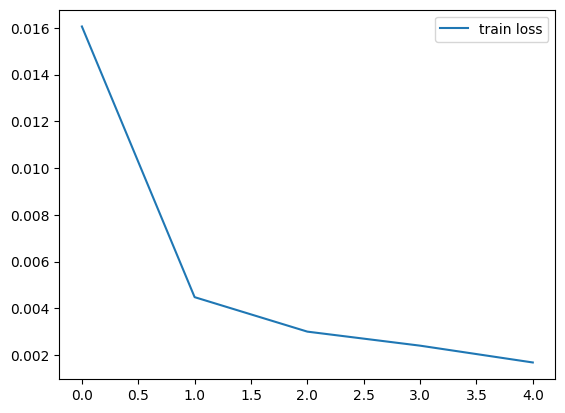

In [17]:
plt.plot(history['train'], label='train loss')
plt.legend()
plt.show()

## Evaluation

Since a Siamese Network learns to measure similarity rather than classify individual samples, we need to assess its performance using a different set of metrics. One common approach is to use the embeddings produced by the network to perform a k-nearest neighbors (k-NN) search. We can then evaluate the network's performance by measuring the accuracy of the k-NN search on a test set. Another approach is to visualize the embeddings in a lower-dimensional space using a dimensionality reduction technique like t-SNE. These evaluations provide insight into how well the model generalizes and whether the learned embeddings are meaningful for downstream tasks.

### Embedding generation

Before we can evaluate the network using k-NN search or t-SNE visualization, we need to generate embeddings for both the training set and the test set. We can do this by passing each dataset through the embedding model and storing the outputs in a separate tensor. The following function generates embeddings for a given dataset using the provided model.

In [18]:
def get_embeddings(model: torch.nn.Module, 
                   data: torch.utils.data.Dataset | torch.utils.data.DataLoader,
                   batch_size: int = 64
                   ) -> tuple[torch.FloatTensor, torch.IntTensor]:
    
    if isinstance(data, torch.utils.data.Dataset):
        data = torch.utils.data.DataLoader(data, batch_size)
    elif not isinstance(data, torch.utils.data.DataLoader):
        raise ValueError('data must be a Dataset or a DataLoader')

    model_device = next(model.parameters()).device
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()

    embeddings = []
    labels = []

    for x, l in loader:
        x = x.to(device)
        with torch.inference_mode():
            y = model(x)
        embeddings.append(y.cpu())
        labels.append(l)

    model = model.to(model_device)

    return torch.cat(embeddings), torch.cat(labels)

In [19]:
train_embeddings, train_labels = get_embeddings(model, train_ds)
test_embeddings,  test_labels  = get_embeddings(model, test_ds)

### k-NN search

The k-NN search is a simple yet effective way to evaluate the quality of embeddings produced by a Siamese Network. We can use the embeddings generated for the test set to find the k-nearest neighbors of each sample in the embedding space. By comparing the predicted labels of the nearest neighbors with the true labels, we can calculate the accuracy of the k-NN search.

In [20]:
# Train a simple k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(train_embeddings.numpy(), train_labels.numpy())

# Evaluate
preds = knn.predict(test_embeddings.numpy())
knn_accuracy = accuracy_score(test_labels.numpy(), preds)

print(f"k-NN Accuracy: {knn_accuracy:.2%}")

k-NN Accuracy: 99.87%


### Visualization

We will use t-SNE to visualize the embeddings produced by the network. t-SNE is a popular technique for visualizing high-dimensional data in a lower-dimensional space. It works by modeling the similarity between data points in the high-dimensional space and the low-dimensional space, then minimizing the difference between these similarities using gradient descent. This results in a 2D or 3D representation of the data that preserves the local structure of the high-dimensional space.

In [21]:
tsne = TSNE(n_components=2, random_state=42)

train_tsne = tsne.fit_transform(train_embeddings)
test_tsne  = tsne.fit_transform(test_embeddings)

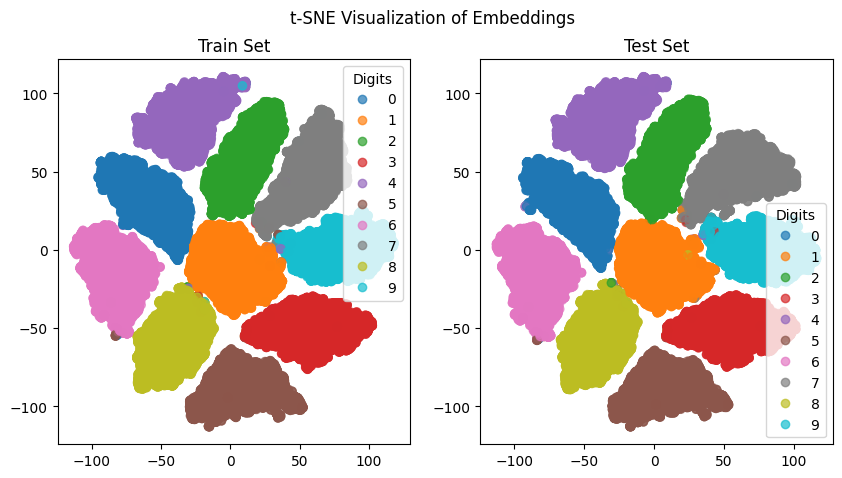

In [24]:
plt.figure(figsize=(10, 5))
plt.suptitle("t-SNE Visualization of Embeddings")

plt.subplot(1, 2, 1)
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels.numpy(), cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("Train Set")

plt.subplot(1, 2, 2)
scatter = plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c=test_labels.numpy(), cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("Test Set")

plt.show()

## Summary

In this tutorial, we implemented a Siamese Network to compare images of handwritten digits from the MNIST dataset. We defined the network architecture and the contrastive loss function. We then trained the Siamese network and evaluated it using k-NN search and t-SNE visualization to assess the quality of the learned embeddings. The results showed that the network was able to learn meaningful representations of the input images, as evidenced by the high accuracy of the k-NN search and the clear separation of classes in the t-SNE visualization.